# TIỀN XỬ LÝ DỮ LIỆU

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=486d6433c2c8dae1389fd0d70020153aebbc95041346e08eae6ac80dbfbf281e
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


## 1. Import thư viện

In [ ]:
# Importing the PySpark Libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Start Spark session
spark = SparkSession.builder \
    .appName("DataPreprocessing") \
    .getOrCreate()

# Importing other necessary libraries
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

# PySpark MLlib for machine learning
from pyspark.ml.feature import StringIndexer, StandardScaler as SparkStandardScaler, PCA as SparkPCA
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Note: Seaborn and Yellowbrick are Python-specific libraries for visualization and will not work with PySpark directly.
# You will need to convert PySpark DataFrames to Pandas DataFrames for visualization purposes when necessary.

## 2. Import dataset + đọc dữ liệu

In [ ]:
# Define the file path
#file_path = "/content/drive/MyDrive/NĂM 3/HK2/BigData/Dataset/marketing_campaign.csv"
file_path = "/content/marketing_campaign.csv"

# Read the dataset
data = spark.read.csv(file_path, sep="\t", header=True, inferSchema=True)

In [ ]:
# Show the number of datapoints
num_data_points = data.count()
print("Number of datapoints:", num_data_points)

# Display the first few rows of the dataset
data.show(5)

Number of datapoints: 2240
+----+----------+----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+-------------+---------+--------+
|  ID|Year_Birth| Education|Marital_Status|Income|Kidhome|Teenhome|Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Z_CostContact|Z_Revenue|Response|
+----+----------+----------+--------------+------+-------+--------+-----------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-

## 3. DATA CLEANING
* Data cleaning
* Feature Engineering

In [ ]:
# Get information about the features
# Print the schema of the DataFrame
data.printSchema()

# Describe the DataFrame to get summary statistics
data.describe().show()

# Count non-null entries for each column to mimic pandas' info() method
from pyspark.sql.functions import col, count, isnan, when

def count_not_null(c):
    return count(when(col(c).isNotNull() & ~isnan(col(c)), c))

non_null_counts = data.agg(*(count_not_null(c).alias(c) for c in data.columns))
non_null_counts.show()

root
 |-- ID: integer (nullable = true)
 |-- Year_Birth: integer (nullable = true)
 |-- Education: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Kidhome: integer (nullable = true)
 |-- Teenhome: integer (nullable = true)
 |-- Dt_Customer: string (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- MntWines: integer (nullable = true)
 |-- MntFruits: integer (nullable = true)
 |-- MntMeatProducts: integer (nullable = true)
 |-- MntFishProducts: integer (nullable = true)
 |-- MntSweetProducts: integer (nullable = true)
 |-- MntGoldProds: integer (nullable = true)
 |-- NumDealsPurchases: integer (nullable = true)
 |-- NumWebPurchases: integer (nullable = true)
 |-- NumCatalogPurchases: integer (nullable = true)
 |-- NumStorePurchases: integer (nullable = true)
 |-- NumWebVisitsMonth: integer (nullable = true)
 |-- AcceptedCmp3: integer (nullable = true)
 |-- AcceptedCmp4: integer (nullable = true)
 |-- AcceptedC

#Some commment and solution
##Missing value have in "Income" Feature => Remove (If replace it may be change the result)
## Dt_Customer have type is string. That is not true ==> change to type DateTime


In [ ]:
# Remove NA values
data = data.na.drop()

# Print the total number of data points after removing rows with missing values
print("The total number of data points after removing the rows with missing values is:", data.count())


The total number of data points after removing the rows with missing values is: 2216


In [ ]:
# Convert "Dt_Customer" column to date format
# data = data.withColumn("Dt_Customer", to_date(col("Dt_Customer"), "dd-MM-yyyy"))
#data = data.withColumn("timestamp", to_timestamp("Dt_Customer"))
#data.select(col("Dt_Customer"),
#    to_timestamp(col("Dt_Customer"), "dd-MM-yyyy").alias("to_timestamp")
#  ).show(truncate=False)
date_format = "dd-MM-yyyy"
data = data.withColumn("Dt_Customer", to_timestamp(data["Dt_Customer"], date_format))
# Print schema to verify data types
data.printSchema()

# Show the first few rows of the cleaned data
data.show()

root
 |-- ID: integer (nullable = true)
 |-- Year_Birth: integer (nullable = true)
 |-- Education: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Kidhome: integer (nullable = true)
 |-- Teenhome: integer (nullable = true)
 |-- Dt_Customer: timestamp (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- MntWines: integer (nullable = true)
 |-- MntFruits: integer (nullable = true)
 |-- MntMeatProducts: integer (nullable = true)
 |-- MntFishProducts: integer (nullable = true)
 |-- MntSweetProducts: integer (nullable = true)
 |-- MntGoldProds: integer (nullable = true)
 |-- NumDealsPurchases: integer (nullable = true)
 |-- NumWebPurchases: integer (nullable = true)
 |-- NumCatalogPurchases: integer (nullable = true)
 |-- NumStorePurchases: integer (nullable = true)
 |-- NumWebVisitsMonth: integer (nullable = true)
 |-- AcceptedCmp3: integer (nullable = true)
 |-- AcceptedCmp4: integer (nullable = true)
 |-- Accept

In [ ]:
ửa

Chúng ta sẽ đi tìm số ngày mà khách hàng đã gắn bó với khách hàng. Ta lấy cột mốc là ngày đăng ký trễ nhất

In [ ]:
from pyspark.sql import functions as F

max_date=data.select(F.max('Dt_customer').alias('max_date')).show()

+-------------------+
|           max_date|
+-------------------+
|2014-06-29 00:00:00|
+-------------------+



In [ ]:
from pyspark.sql import functions as F
data.select(F.min('Dt_customer').alias('min_date')).show()

+-------------------+
|           min_date|
+-------------------+
|2012-07-30 00:00:00|
+-------------------+



In [ ]:
d1 = data.agg(max("Dt_Customer")).collect()[0][0]
print(d1)

2014-06-29 00:00:00


In [ ]:
d1 = data.agg(max("Dt_Customer")).collect()[0][0]
data = data.withColumn("CustomerFor", datediff(lit(d1),col(("Dt_Customer"))))
data = data.withColumn("CustomerFor",col("CustomerFor").cast(IntegerType()))

In [ ]:
data.show()

+----+----------+----------+--------------+------+-------+--------+-------------------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+-------------+---------+--------+-----------+
|  ID|Year_Birth| Education|Marital_Status|Income|Kidhome|Teenhome|        Dt_Customer|Recency|MntWines|MntFruits|MntMeatProducts|MntFishProducts|MntSweetProducts|MntGoldProds|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Z_CostContact|Z_Revenue|Response|CustomerFor|
+----+----------+----------+--------------+------+-------+--------+-------------------+-------+--------+---------+---------------+---------------+----------------+------------+-----------------+---------------+------------------

Kiểm tra các biến phân loại trong dataframe

Theo mô tả, ta có các biến phân loại như sau: Education, Marital_Status. Ngoài ra còn một số dữ liệu khác có thể phân loại như Income, kidhome,teenhome

In [ ]:
# Tạo một Spark session
spark = SparkSession.builder.appName("ValueCounts").getOrCreate()
# Xem biến phân loại Education
Education_counts = data.groupBy("Education").count()
Education_counts.show()
# Xem biến phân loại Marital_Status
Marital_counts = data.groupBy("Marital_Status").count()
Marital_counts.show()

+----------+-----+
| Education|count|
+----------+-----+
|  2n Cycle|  200|
|       PhD|  481|
|    Master|  365|
|Graduation| 1116|
|     Basic|   54|
+----------+-----+

+--------------+-----+
|Marital_Status|count|
+--------------+-----+
|          YOLO|    2|
|      Together|  573|
|       Married|  857|
|        Absurd|    2|
|         Widow|   76|
|      Divorced|  232|
|         Alone|    3|
|        Single|  471|
+--------------+-----+



Để thuận tiện hơn cho việc phân loại. Chúng ta sẽ thay đổi 1 số biến cũng như loại bỏ những biến không cần thiết ra khỏi dataset

In [ ]:
# Thay vì để ngày sinh chúng ta sẽ tạo ra 1 biến tuổi của khách hàng cho đến hiện tại.
data = data.withColumn("Age", 2024 - col("Year_Birth"))
# Tính tổng giá trị mà 1 khách hàng đã mua ở cửa hàng từ lúc tham gia
data = data.withColumn("Total_Spent", col("MntWines")+ col("MntFruits")+ col("MntMeatProducts")+ col("MntFishProducts")+ col("MntSweetProducts")+ col("MntGoldProds") )
# Gộp 2 cột có con nhỏ tuổi và con lớn vào thành có con
data = data.withColumn("Children", col("Kidhome") + col("Teenhome"))
# Ở Cột Maritual_Status mặc dù nó chia ra thành độc thân hay kết hôn hay sống chung
# Vì thế ta sẽ tạo 1 cột thay thế cột này với 2 segment là 1 mình hoặc sống theo cặp
data = data.withColumn("Living_With",
                   when((col("Marital_Status") == "Married") | (col("Marital_Status") == "Together"), "Partner")
                   .when((col("Marital_Status") == "Widow") | (col("Marital_Status") == "YOLO") | (col("Marital_Status") == "Divorced") | (col("Marital_Status") == "Single"), "Alone")
                   .when(col("Marital_Status") == "Absurd", "Alone")
                   .otherwise(col("Marital_Status")))
# Tương tự như thế chúng ta trình độ học vấn thành 3 segment: Undergraduate, Graduation và Master
data = data.withColumn("Education",
                   when(col("Education").isin(["Basic", "2n Cycle"]), "Undergraduate")
                   .when(col("Education").isin(["Graduation"]), "Graduate")
                   .when(col("Education").isin(["Master", "PhD"]), "Postgraduate")
                   .otherwise(col("Education")))
# Đổi tên column sản phẩm
data = data.withColumnRenamed("MntWines", "Wines") \
       .withColumnRenamed("MntFruits", "Fruits") \
       .withColumnRenamed("MntMeatProducts", "Meat") \
       .withColumnRenamed("MntFishProducts", "Fish") \
       .withColumnRenamed("MntSweetProducts", "Sweets") \
       .withColumnRenamed("MntGoldProds", "Gold")

In [ ]:
# Sau khi đã biến đổi dữ liệu, bây giờ ta sẽ loại bỏ những cột ko cần  thiết
# Xác định các cột sẽ loại bỏ
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(*to_drop)
data.show()

+-------------+------+-------+--------+-------+-----+------+----+----+------+----+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------+-----------+---+-----------+--------+-----------+
|    Education|Income|Kidhome|Teenhome|Recency|Wines|Fruits|Meat|Fish|Sweets|Gold|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Response|CustomerFor|Age|Total_Spent|Children|Living_With|
+-------------+------+-------+--------+-------+-----+------+----+----+------+----+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------+-----------+---+-----------+--------+-----------+
|     Graduate| 58138|      0|       0|     58|  635|    88| 546| 172|    88|  88|   

In [ ]:
#Bổ sung cột Is_Parent vì khí có con cái cũng sẽ ảnh hưởng đến hành vi mua hàng
# của người dùng.
data = data.withColumn("Is_Parent", when(data["Children"] > 0, 1).otherwise(0))
data.show()

+-------------+------+-------+--------+-------+-----+------+----+----+------+----+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------+-----------+---+-----------+--------+-----------+---------+
|    Education|Income|Kidhome|Teenhome|Recency|Wines|Fruits|Meat|Fish|Sweets|Gold|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Response|CustomerFor|Age|Total_Spent|Children|Living_With|Is_Parent|
+-------------+------+-------+--------+-------+-----+------+----+----+------+----+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------+-----------+---+-----------+--------+-----------+---------+
|     Graduate| 58138|      0|       0|     58|  635|  

In [ ]:
data.describe().show()

+-------+-------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-------------------+-----------------+-----------------+-------------------+------------------+-------------------+-------------------+--------------------+-------------------+-------------------+------------------+------------------+-----------------+------------------+-----------+-------------------+
|summary|    Education|            Income|           Kidhome|          Teenhome|          Recency|             Wines|            Fruits|              Meat|             Fish|            Sweets|             Gold| NumDealsPurchases|   NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|       AcceptedCmp3|      AcceptedCmp4|       AcceptedCmp5|       AcceptedCmp1|        AcceptedCmp2|           Complain|           Response|    

#NHẬN XÉT

Ông cao nhất 131 tuổi lận (Do là bảng của quá khứ mà tính tuổi ở 2024 nên tính mấy cha qua đời nữa)
Vì thế chúng ta sẽ loại bỏ một số outlier. Để làm điều này sẽ sử dụng scatter plot để xem sự phân bố một số thuộc tính liên quan sẽ xảy ra sự vô lí

Phát hiện outlier nằm ở Age và Icome.
Xác  định được điều kiện để loại  bỏ outlier là Age <90 và Income <600000

<Figure size 800x550 with 0 Axes>

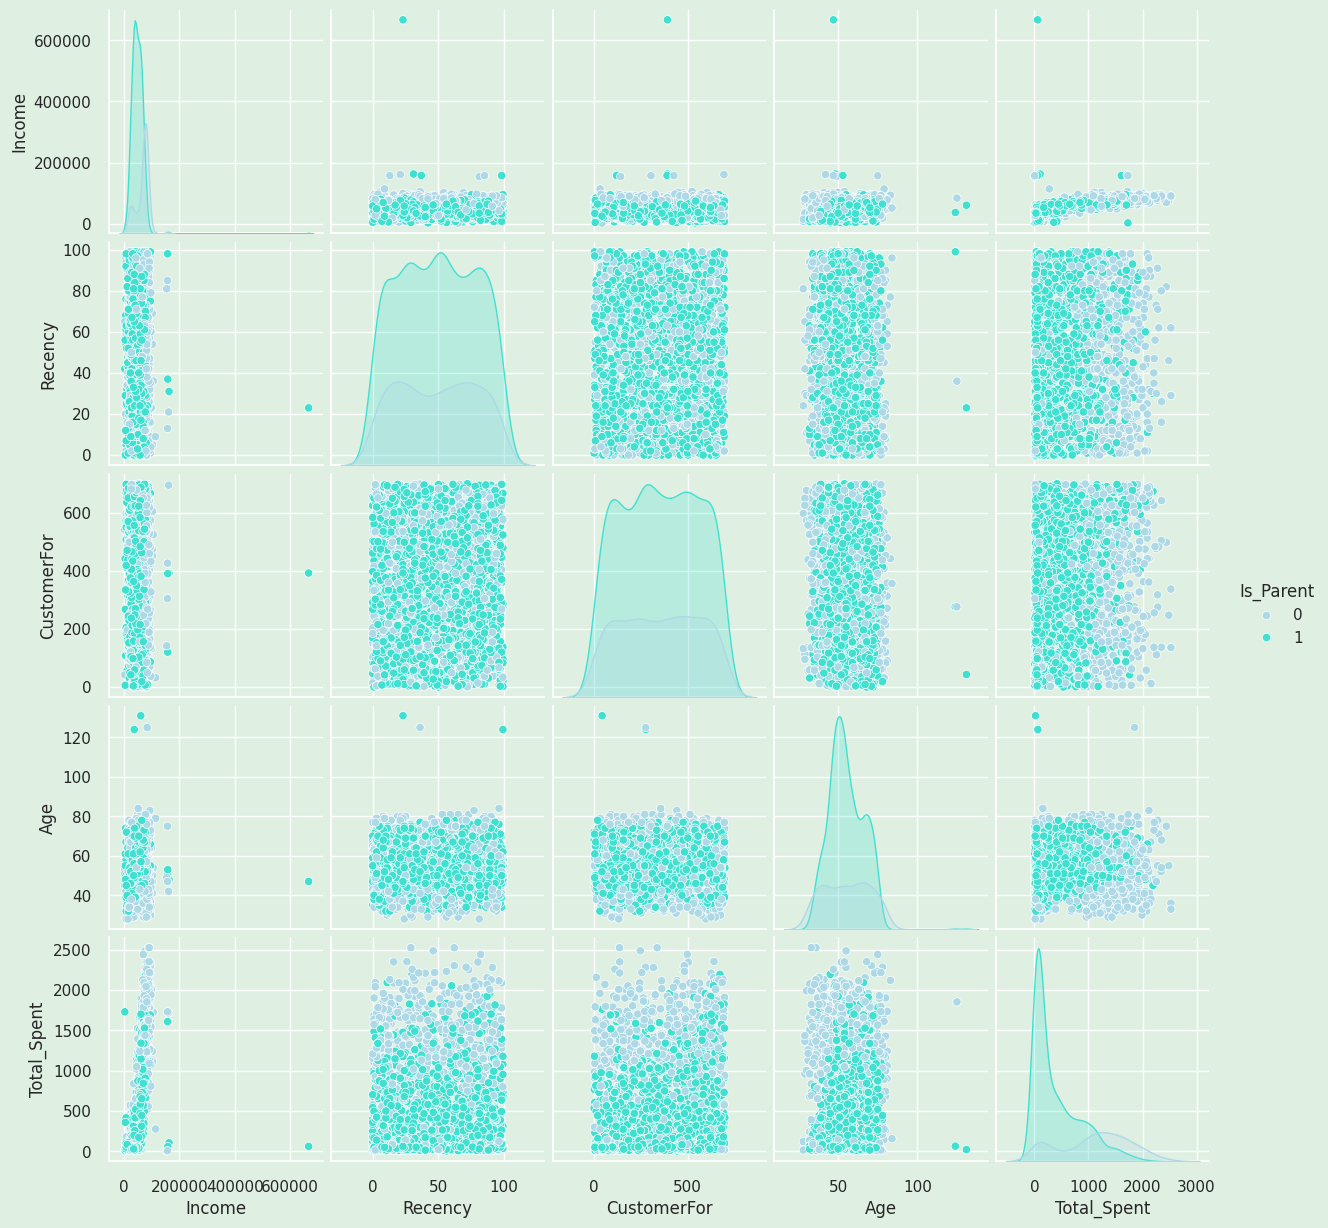

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors

sns.set(rc={"axes.facecolor": "#DFF0E2", "figure.facecolor": "#DFF0E2"})
palette = ["#ADD8E6", "#40E0D0", "#007BA7", "#87CEEB", "#00BFFF", "#F3AB60"]
cmap = colors.ListedColormap(["#ADD8E6", "#40E0D0", "#007BA7", "#87CEEB", "#00BFFF", "#F3AB60"])

To_Plot = ["Income", "Recency", "CustomerFor", "Age", "Total_Spent", "Is_Parent"]

data_pandas = data.select(To_Plot).toPandas()
plt.figure()
sns.pairplot(data_pandas, hue="Is_Parent", palette=["#ADD8E6", "#40E0D0"])
plt.show()


In [ ]:
from pyspark.sql import functions as F

data = data.filter((F.col("Age") < 90) & (F.col("Income") < 600000))

total_data_points = data.count()
print("The total number of data points after removing the outliers are:", total_data_points)


The total number of data points after removing the outliers are: 2212


In [ ]:
data.dtypes

[('Education', 'string'),
 ('Income', 'int'),
 ('Kidhome', 'int'),
 ('Teenhome', 'int'),
 ('Recency', 'int'),
 ('Wines', 'int'),
 ('Fruits', 'int'),
 ('Meat', 'int'),
 ('Fish', 'int'),
 ('Sweets', 'int'),
 ('Gold', 'int'),
 ('NumDealsPurchases', 'int'),
 ('NumWebPurchases', 'int'),
 ('NumCatalogPurchases', 'int'),
 ('NumStorePurchases', 'int'),
 ('NumWebVisitsMonth', 'int'),
 ('AcceptedCmp3', 'int'),
 ('AcceptedCmp4', 'int'),
 ('AcceptedCmp5', 'int'),
 ('AcceptedCmp1', 'int'),
 ('AcceptedCmp2', 'int'),
 ('Complain', 'int'),
 ('Response', 'int'),
 ('CustomerFor', 'int'),
 ('Age', 'int'),
 ('Total_Spent', 'int'),
 ('Children', 'int'),
 ('Living_With', 'string'),
 ('Is_Parent', 'int')]

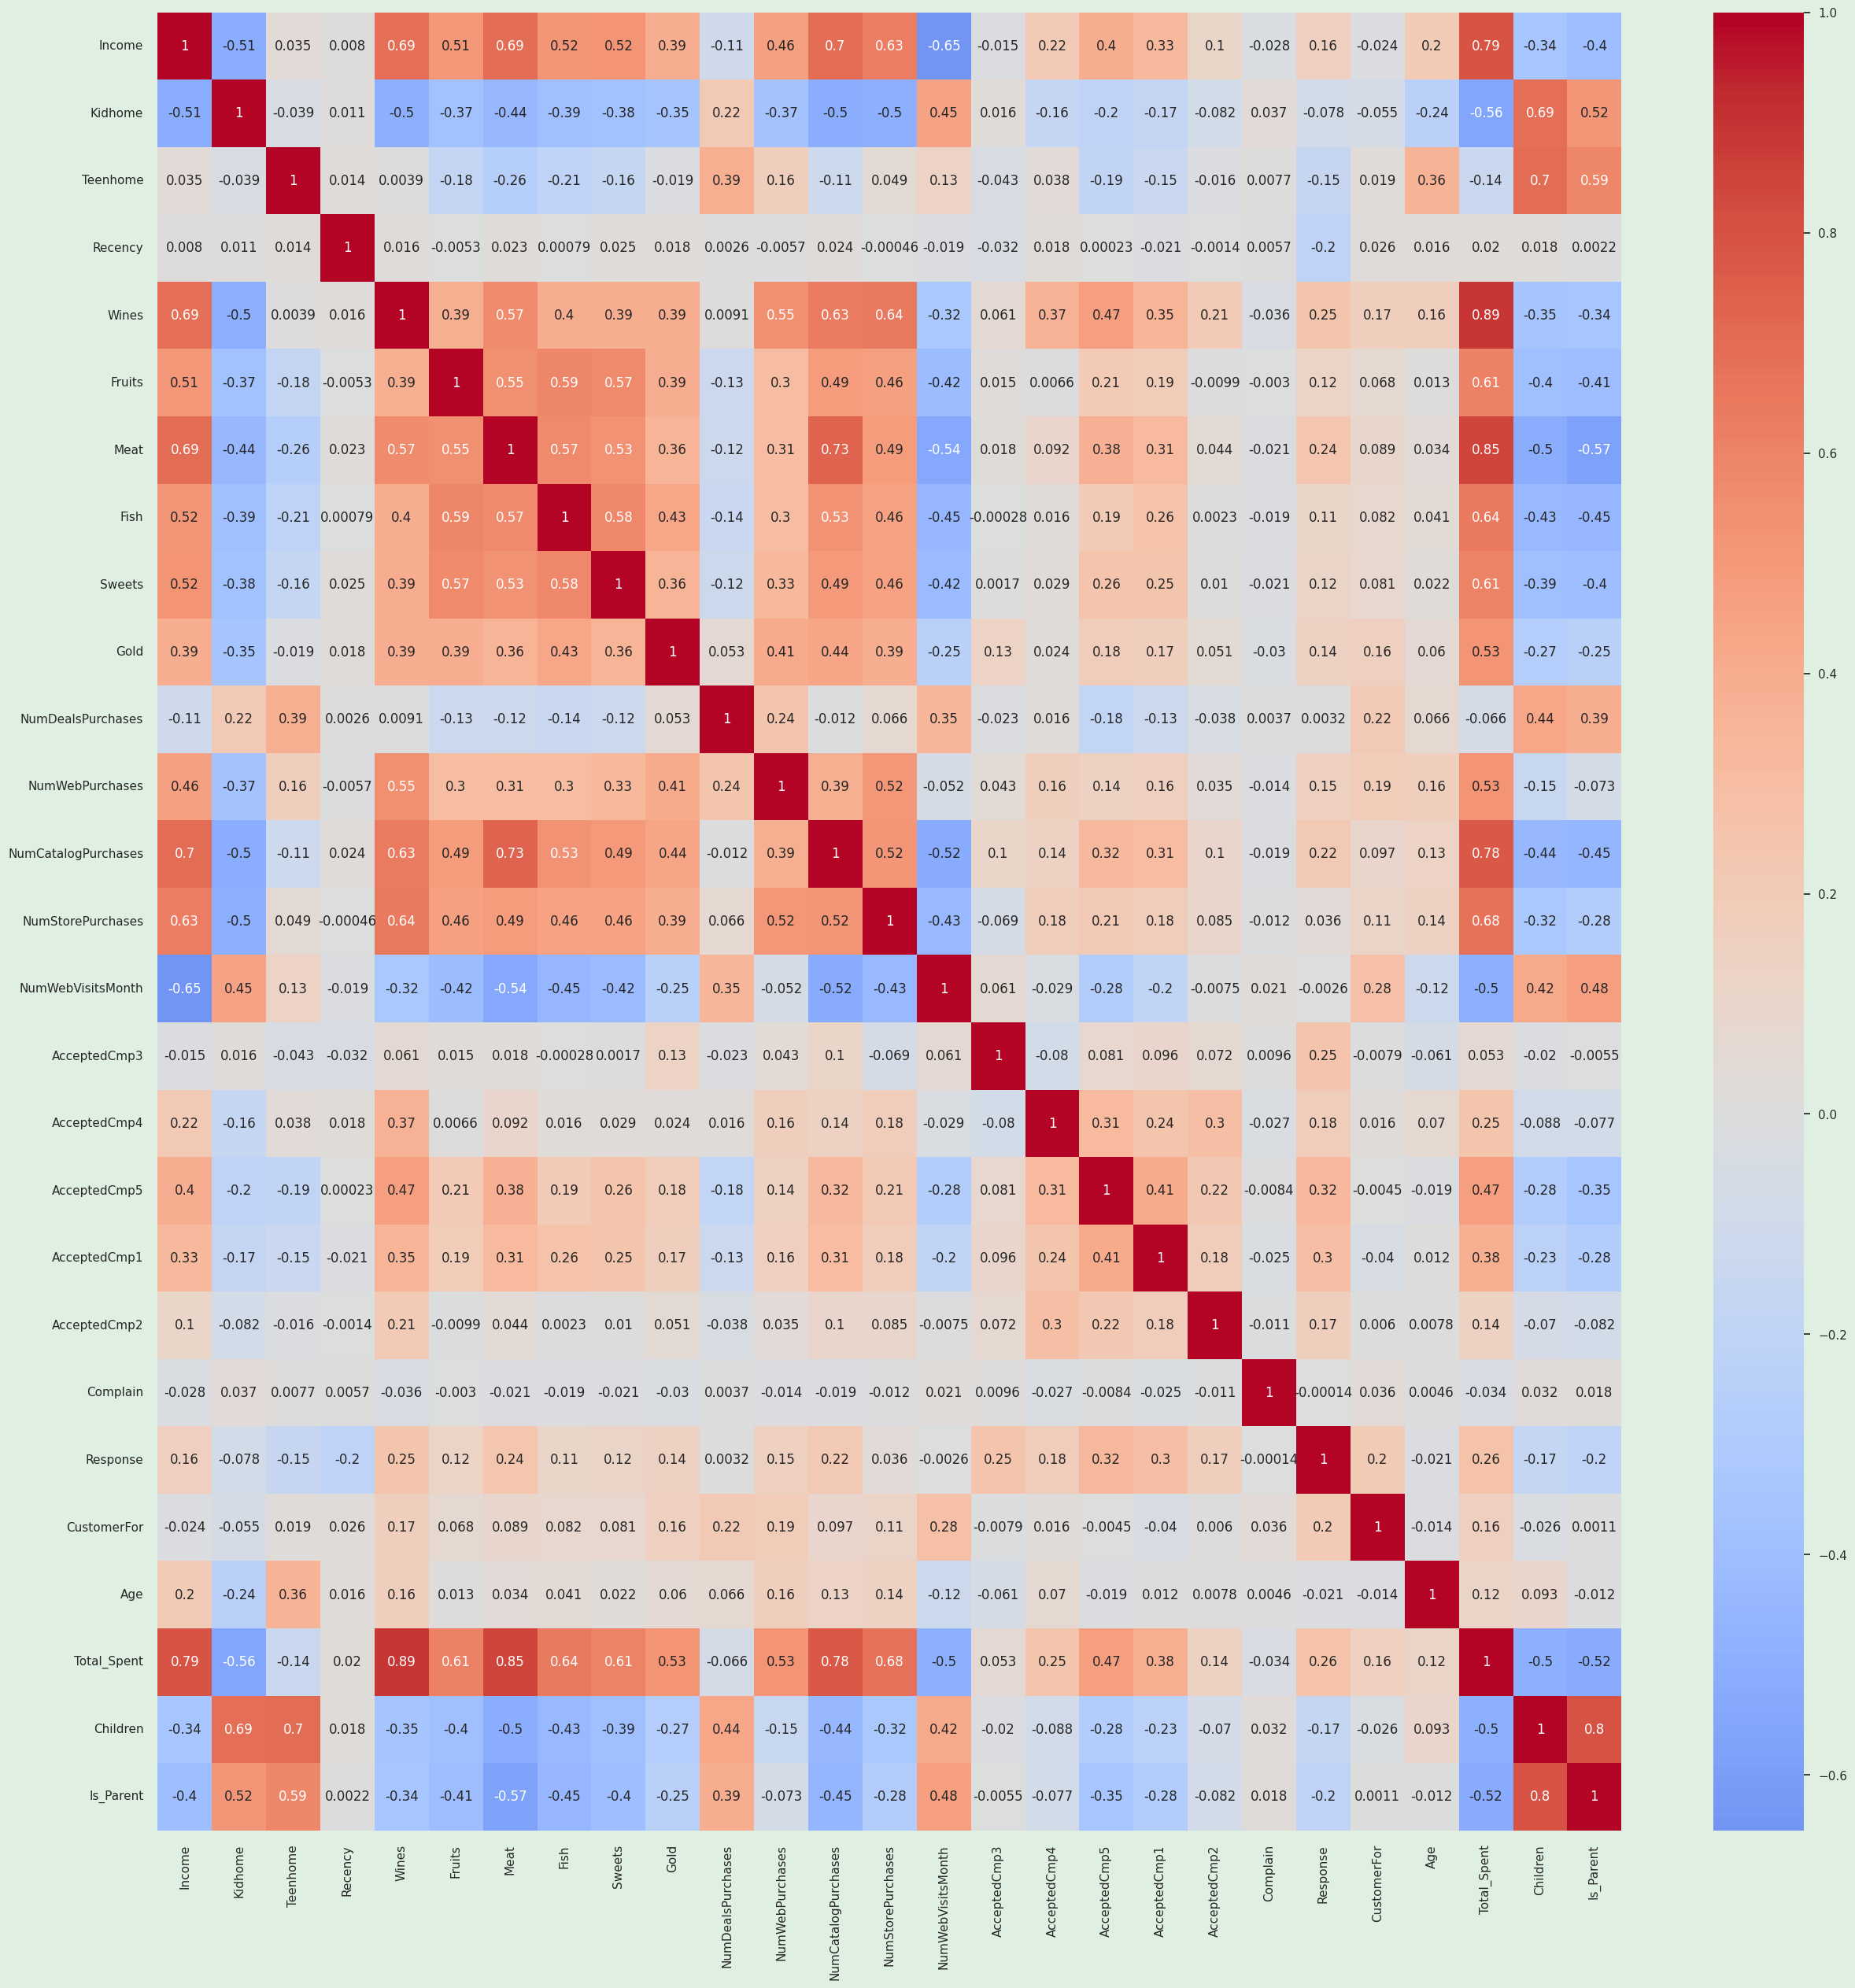

In [ ]:
data_pandas = data.toPandas()
# Xem xét độ tương quan của bộ dataset
#Loại bỏ các biến phân loại ra
data_numeric = data_pandas.select_dtypes(include=['int'])

corrmat = data_numeric.corr()

# Plot the heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(corrmat, annot=True, cmap='coolwarm', center=0)
plt.show()

#  Giờ sẽ chuẩn bị cho clustering

In [ ]:
# Xem lại các biến phân loại (Đó sẽ là các biến có kiểu dữ liệu ko phải int)

In [ ]:
column_types = data.dtypes

categorical_cols = [col_name for col_name, data_type in column_types if data_type == 'string']

print("Categorical variables in the dataset:", categorical_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [ ]:
from pyspark.ml.feature import StringIndexer

# Initialize a StringIndexer for each categorical column
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index").fit(data) for col in categorical_cols]


# Apply the StringIndexers to the DataFrame
for indexer in indexers:
    data = indexer.transform(data)

# Drop the original categorical columns
data = data.drop(*categorical_cols)

print("All features are now numerical")


All features are now numerical


In [ ]:
data.show()

+------+-------+--------+-------+-----+------+----+----+------+----+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------+-----------+---+-----------+--------+---------+---------------+-----------------+
|Income|Kidhome|Teenhome|Recency|Wines|Fruits|Meat|Fish|Sweets|Gold|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Response|CustomerFor|Age|Total_Spent|Children|Is_Parent|Education_index|Living_With_index|
+------+-------+--------+-------+-----+------+----+----+------+----+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------+-----------+---+-----------+--------+---------+---------------+-----------------+
| 58138|      0|       0|     5

In [ ]:
# Đổi tên 2 cột phân loại vừa đổi từ chữ sang số

data = data.withColumnRenamed("Education_index", "Education")
data = data.withColumnRenamed("Living_With_index", "Living_With")

In [ ]:
data.show()

+------+-------+--------+-------+-----+------+----+----+------+----+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------+-----------+---+-----------+--------+---------+---------+-----------+
|Income|Kidhome|Teenhome|Recency|Wines|Fruits|Meat|Fish|Sweets|Gold|NumDealsPurchases|NumWebPurchases|NumCatalogPurchases|NumStorePurchases|NumWebVisitsMonth|AcceptedCmp3|AcceptedCmp4|AcceptedCmp5|AcceptedCmp1|AcceptedCmp2|Complain|Response|CustomerFor|Age|Total_Spent|Children|Is_Parent|Education|Living_With|
+------+-------+--------+-------+-----+------+----+----+------+----+-----------------+---------------+-------------------+-----------------+-----------------+------------+------------+------------+------------+------------+--------+--------+-----------+---+-----------+--------+---------+---------+-----------+
| 58138|      0|       0|     58|  635|    88| 546| 172|    88|  88

In [ ]:
ds_download = data.toPandas()
# Lưu DataFrame pandas dưới dạng file CSV
ds_download.to_csv('data_fixed.csv', index=False)

In [ ]:
#Loại bỏ những biến không cần thiết về khuyến mãi
ds = data

cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(*cols_del)

# Sau đây chúng ta sẽ chuẩn hóa dữ liệu dựa trên công thức Z-score
              x_scaled = (x-mean)/std
Trong đó: x là dữ liệu thuộc 1 thuộc tính
mean là trung bình của thuộc tính
std là độ lệch chuẩn của thuộc tính

In [ ]:
# Xem tên các cột cần chuyển hóa
input_features = ds.columns
print(input_features)

['Income', 'Kidhome', 'Teenhome', 'Recency', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'CustomerFor', 'Age', 'Total_Spent', 'Children', 'Is_Parent', 'Education', 'Living_With']


In [ ]:
# Tính toán giá trị trung bình và độ lệch chuẩn cho mỗi đặc trưng
# Tạo một mảng chứa giá trị trung bình và độ lệch chuẩn của mỗi đặc trưng
# Tính toán giá trị trung bình và độ lệch chuẩn cho mỗi đặc trưng
summary = ds.select(
    [mean(c).alias(c + '_mean') for c in ds.columns] +
    [stddev(c).alias(c + '_stddev') for c in ds.columns]
).collect()[0]

# Tạo dictionary để lưu trữ giá trị trung bình và độ lệch chuẩn
means = {col_name: summary[col_name + '_mean'] for col_name in ds.columns}
stddevs = {col_name: summary[col_name + '_stddev'] for col_name in ds.columns}
print(means)
print(stddevs)

{'Income': 51958.81057866185, 'Kidhome': 0.44168173598553345, 'Teenhome': 0.505877034358047, 'Recency': 49.019439421338156, 'Wines': 305.2875226039783, 'Fruits': 26.329566003616637, 'Meat': 167.02983725135624, 'Fish': 37.64873417721519, 'Sweets': 27.046564195298373, 'Gold': 43.92585895117541, 'NumDealsPurchases': 2.324593128390597, 'NumWebPurchases': 4.088155515370706, 'NumCatalogPurchases': 2.672242314647378, 'NumStorePurchases': 5.806509945750452, 'NumWebVisitsMonth': 5.321428571428571, 'CustomerFor': 353.7142857142857, 'Age': 55.08634719710669, 'Total_Spent': 607.2680831826401, 'Children': 0.9475587703435805, 'Is_Parent': 0.7142857142857143, 'Education': 0.6098553345388789, 'Living_With': 0.35443037974683544}
{'Income': 21527.27884405048, 'Kidhome': 0.5369549739282555, 'Teenhome': 0.5442531463943723, 'Recency': 28.94312147062817, 'Wines': 337.32293989322864, 'Fruits': 39.74405192823287, 'Meat': 224.25449339256858, 'Fish': 54.77203307089303, 'Sweets': 41.090991263814914, 'Gold': 51.7

In [ ]:
# Test công thức trước khi chạy
print ("Trung bình thu nhập là: ",means['Income'])
print ("Độ lệch chuẩn thu nhập là: ",stddevs['Income'])
print("Giá trị đầu tiên của đặc trưng thu nhập là: ",ds.select('Income').first()[0])
test_scale = (ds.select('Income').first()[0] - means['Income']) / stddevs['Income']
print("Chuẩn hóa: ",test_scale)

Trung bình thu nhập là:  51958.81057866185
Độ lệch chuẩn thu nhập là:  21527.27884405048
Giá trị đầu tiên của đặc trưng thu nhập là:  58138
Chuẩn hóa:  0.28703996757332395


In [ ]:
# Kết quả như ý muốn nên chạy cho toàn bộ dataset
for col_name in ds.columns:
    ds = ds.withColumn(col_name, (col(col_name) - means[col_name]) / stddevs[col_name])

# Hiển thị kết quả
ds.show()

+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+
|              Income|            Kidhome|           Teenhome|            Recency|               Wines|              Fruits|                Meat|                Fish|              Sweets|                Gold|  NumDealsPurchases|     NumWebPurchases| NumCatalogPurchases|   NumStorePurchases|   NumWebVisitsMonth|         CustomerFor|                 Age|         Total_Spent|           Children|          Is_Parent|          Education|        Living_With|
+--------------------+-------------------+-------------------+-------------------+------

In [ ]:
ds_download = ds.toPandas()
# Lưu DataFrame pandas dưới dạng file CSV
ds_download.to_csv('standardized_data.csv', index=False)

In [ ]:
#df.write.csv("/path/to/output/csv/file", header=True)